In [15]:
#imports
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [78]:
#functionalities
def sigmoid(x):
    s = 1./(1+np.exp(-x))
    return s
def sigmoidPrime(x):
    return sigmoid(x)*(1-sigmoid(x))

def relu(x):
    return np.maximum(x, 0.0)
def reluPrime(x):
    return np.where(x>=0, 1.0, 0.0)

def softmax(x):
    s = np.exp(x)
    return s/np.expand_dims(np.sum(s, axis=1), axis=1)

def Initialize(inp, out):
    """in/out number of units in in/out layers.
    Returns initialized weights (inp+bias included) x out."""
    sigma = 0.01
    return np.random.normal(0, sigma, (inp, out)) #np.random.randn(inp, out) #np.zeros(shape=(inp+1,out))

def InitializeNetworkWeights(hidden_layer_sizes):
    #initialize all weights:
    W = []
    for i in range(1,len(hidden_layer_sizes)):
        W.append(Initialize(hidden_layer_sizes[i-1]+1, hidden_layer_sizes[i]))
    return W

def CostMultiple(Y,p):
    """Y of size N x m, N samples, m classes.
    p also: p=softmax(X*w)"""
    return -np.sum(np.multiply(Y,np.log(p)))/np.size(Y,0)

def Accuracy(Y, p):
    Y_pred = np.argmax(p, 1)
    Y = np.argmax(Y, 1)
    return (np.sum(Y==Y_pred))/len(Y)

def PassForward(X, wb):
    """X shaped Nxfeatures, wb featuresIn x featuresOut.
    returns NxfeaturesOut p forward pass of model."""
    X = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
    return np.dot(X, wb)#X@wb

def PassBackward(X, wb, activationPrime):
    return 0

def Predict(X, wb):
    """ X is a batch of images on which to do the forward pass.
        (Size 28x28, but flattened, for MNIST, so sized n x 784).
        Weights is a matrix of size 784(+1 bias) x out/encoding_size."""
    #flatten the image before inputing i, and add 1 for bias!
    #img = img.flatten()
    X = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
    return softmax(X@wb) #size n x num_classes/encoding_size

def PassForwardNetwork(X, W, activation):
    """Pass forward step through the whole network. X is input data, W is a list of weight
    matrices per layer (W[0] is the first layer weights, W[1] second... W[-1]is the last,
    classification layer weights). activation is the function to use as activation in every
    layer, except the last one, which is classification one so we use softmax."""
    p = [X]
    z = []
    for layer in range(len(W)-1):
        ztmp = PassForward(p[layer], W[layer])
        z.append(ztmp)
        p.append(activation(ztmp))
    #now the last, classification layer with the softmax:
    p.append(Predict(p[-1], W[-1]))
    #we return the entire list of z's and p's because they will be needed in backward pass
    return z,p

def PassBackwardNetwork(W, Ps, Zs, Y, activationPrime):
    N = Ps[0].shape[0]
    odvodi = []
    previous = Ps[-1] - Y
    odvodi.append(previous)
    for layer in range(1,len(W)):
        #first extend dimensions for bias:
        z, p = Zs[-layer], Ps[-layer-1]
        #z = np.concatenate((z, np.ones((z.shape[0],1))), axis=1)
        p = np.concatenate((p, np.ones((p.shape[0],1))), axis=1)


    #  print(odvodi[-1].shape, W[-layer].T.shape, z.shape, p.shape)
        tmp = (odvodi[-1] @ W[-layer][:-1,:].T) * activationPrime(z) #remove last row of W (which is bias).
        odvodi[-1] = (p.T@(1/N*odvodi[-1])) #?*1/N
        odvodi.append( tmp )
    p = Ps[-len(W)-1]
    p = np.concatenate((p, np.ones((p.shape[0],1))), axis=1)
    odvodi[-1] = p.T@odvodi[-1]/N #to bi moglo bit lih Ps[0]
    odvodi.reverse()
    return odvodi

def UpdateWeights(W, dW, learning_rate, dV, momentum, normalize=None):
    for i in range(len(W)):
        dV[i] = momentum*dV[i] - learning_rate*dW[i]
        W[i] = W[i] + dV[i]
    if normalize:
        for i in range(len(W)):
            W[i] = W[i]/np.max(np.abs(W[i]))
    return dV, W


In [129]:
#get data
#X, Y, X_test, Y_test = load_mnist()
(X, Y), (X_test, Y_test) = mnist.load_data()
X = X.reshape(-1, 784) / 255.
X_test = X_test.reshape(-1, 784) / 255.

In [130]:
(X.shape, Y.shape)
#Y = np.expand_dims(Y, axis=1)
#Y_test = np.expand_dims(Y_test, axis=1)
from keras.utils import to_categorical
Y = to_categorical(Y)
Y_test = to_categorical(Y_test)
(X.shape, Y_test.shape)


((60000, 784), (10000, 10))

In [56]:
#k=15
#X_all = X
#X = X[0:k,:]
#Y_all = Y
#Y = Y[0:k, :]

In [164]:
#Running the code:

#with hidden layers
m = 10
hidden_layer_sizes = [X.shape[1], 512, 512, m]
#initialize all weights:
W = InitializeNetworkWeights(hidden_layer_sizes)
#[W[0].shape, W[1].shape, W[2].shape]
dV = [0.0 for i in W]

momentum = 0.0
batchsize = 128
learning_rate = 0.1
activfun, activfunPrime = relu, reluPrime #sigmoid, sigmoidPrime
epochs = 30

In [165]:
#epochs = 10
#learning_rate = 0.001
import time 

vseh = X.shape[0]
num_batches = int(np.ceil(vseh/batchsize))

batch_acc = np.zeros(num_batches)
batch_cost = np.zeros(num_batches)
epoch = 0
acc_test, cost_test = [], []
acc, cost = [], []
p_test = PassForwardNetwork(X_test, W, activation=activfun)[1]
acc_test.append(Accuracy(Y_test, p_test[-1]))
cost_test.append(CostMultiple(Y_test, p_test[-1]))
#now train :)
print("learning rate = ", learning_rate)
start = time.time()
while acc_test[-1]<0.98:
    epoch += 1
    perm = np.random.permutation(vseh)
    X = X[perm,:]
    Y = Y[perm,]

    for batch in range(num_batches):
        X_train = X[batch*batchsize:(batch+1)*batchsize,:]
        Y_train = Y[batch*batchsize:(batch+1)*batchsize,]

        N = X_train.shape[0]

        #forward:
        Zs,Ps = PassForwardNetwork(X_train, W, activation=activfun)

        batch_acc[batch] = Accuracy(Y_train, Ps[-1])
        batch_cost[batch] = CostMultiple(Y_train, Ps[-1])

        #backward (calculate derivatives):
        dW = PassBackwardNetwork(W, Ps, Zs, Y_train, activationPrime=activfunPrime)
        #do update for each weight:
        dV, W = UpdateWeights(W, dW, learning_rate, dV, momentum) #we remember the decaying sum of grads in dV.
        
    p_test = PassForwardNetwork(X_test, W, activation=activfun)[1]
    acc_test.append(Accuracy(Y_test, p_test[-1]))
    cost_test.append(CostMultiple(Y_test, p_test[-1]))
    #if epoch%10==0: #(acc_test[-1]-acc_test[-2]<=0.003):
    #    learning_rate = learning_rate/2
        #print("learning rate = ", learning_rate)
    


    acc.append(np.mean(batch_acc))
    cost.append(np.mean(batch_cost))
    #if epoch%5==0:
    print('Epoch {2}. Test acc: {0}, Train acc: {1}'.format(acc_test[-1], acc[-1], epoch))
end = time.time()
print(end-start)

learning rate =  0.1
Epoch 1. Test acc: 0.8779, Train acc: 0.6277596393034826
Epoch 2. Test acc: 0.9237, Train acc: 0.9027241027007818
Epoch 3. Test acc: 0.9423, Train acc: 0.9310478855721392
Epoch 4. Test acc: 0.9542, Train acc: 0.947378065031983
Epoch 5. Test acc: 0.9613, Train acc: 0.9584388326226013
Epoch 6. Test acc: 0.9652, Train acc: 0.9660236762615494
Epoch 7. Test acc: 0.969, Train acc: 0.9717150852878464
Epoch 8. Test acc: 0.9711, Train acc: 0.9756074538024164
Epoch 9. Test acc: 0.9737, Train acc: 0.9788612739872068
Epoch 10. Test acc: 0.976, Train acc: 0.9813710465529495
Epoch 11. Test acc: 0.9745, Train acc: 0.9839141346837242
Epoch 12. Test acc: 0.9771, Train acc: 0.986218461265103
Epoch 13. Test acc: 0.9779, Train acc: 0.988250710732054
Epoch 14. Test acc: 0.9791, Train acc: 0.9896832800284292
Epoch 15. Test acc: 0.9762, Train acc: 0.9907493781094527
Epoch 16. Test acc: 0.9796, Train acc: 0.9918876599147122
Epoch 17. Test acc: 0.977, Train acc: 0.9932924662402275
Epoch 18

In [119]:
acc_old.append(acc)
acc_test_old.append(acc_test[1:])
cost_old.append(cost)
cost_test_old.append(cost_test)

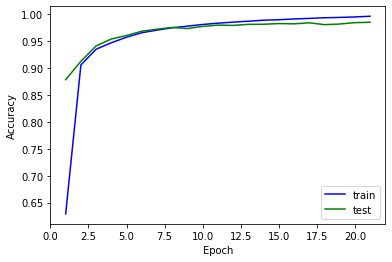

In [162]:
#plotting
#acc_old = acc
#acc_old_test = acc_test

epoch_count = [i+1 for i in range(21)]
plt.plot(epoch_count, acc[0:21], 'b')
plt.plot(epoch_count, acc_test[1:22], 'g')
plt.legend(['train', 'test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();
        

In [32]:
acc_test

[0.023,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]